In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D

In [2]:
data_list=[]
for i in range(5):
    data = pd.read_csv('/kaggle/input/traffic-prediction-data/d11_text_station_5min_2019_09_0'+str(i+1)+'.csv',header=None)
    data = data.iloc[:,[0,1,9]]
    data.columns=['time','station_num','flow']
    if len(data_list) == 0:
        data_list.append(data)
    else:
        data_list[0] = pd.concat([data_list[0],data],ignore_index=True)
data=data_list[0]
data

,time,station_num,flow
0,09/01/2019 00:00:00,1100313,NaN
1,09/01/2019 00:00:00,1100323,NaN
2,09/01/2019 00:00:00,1100326,14.0
3,09/01/2019 00:00:00,1100330,5.0
4,09/01/2019 00:00:00,1100333,NaN
...,...,...,...
2149915,09/05/2019 23:55:00,1127007,7.0
2149916,09/05/2019 23:55:00,1127014,3.0
2149917,09/05/2019 23:55:00,1127026,107.0
2149918,09/05/2019 23:55:00,1127030,22.0


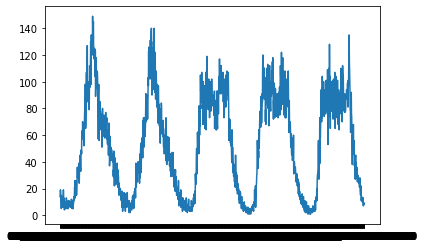

In [3]:
data_1100326 = data.loc[data['station_num']==1100326].dropna(subset=['flow'])
plt.plot(data_1100326['time'],data_1100326['flow'])

In [4]:
data=data.groupby('station_num').filter(lambda x : x.flow.count()!=0)
data.fillna(method='pad',axis=0,inplace=True)
grouped=data.groupby('time')
grouped.count()

,station_num,flow
time,,
09/01/2019 00:00:00,1426,1426
09/01/2019 00:05:00,1426,1426
09/01/2019 00:10:00,1426,1426
09/01/2019 00:15:00,1426,1426
09/01/2019 00:20:00,1426,1426
...,...,...
09/05/2019 23:35:00,1426,1426
09/05/2019 23:40:00,1426,1426
09/05/2019 23:45:00,1426,1426


In [5]:
data_flow=[]
for name, group in grouped:
    data_flow.append(group['flow'].values)
data_flow=np.array(data_flow)
pd.DataFrame(data_flow)

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,14.0,5.0,13.0,12.0,13.0,3.0,22.0,14.0,7.0,6.0,...,0.0,36.0,0.0,178.0,175.0,4.0,4.0,189.0,54.0,100.0
1,15.0,4.0,14.0,9.0,9.0,2.0,17.0,11.0,4.0,6.0,...,23.0,25.0,0.0,137.0,150.0,6.0,5.0,179.0,38.0,52.0
2,19.0,9.0,4.0,8.0,6.0,1.0,21.0,12.0,8.0,11.0,...,13.0,32.0,0.0,172.0,181.0,6.0,6.0,187.0,55.0,65.0
3,17.0,5.0,5.0,4.0,13.0,1.0,13.0,16.0,8.0,4.0,...,24.0,30.0,4.0,162.0,161.0,8.0,3.0,183.0,43.0,67.0
4,10.0,4.0,6.0,8.0,8.0,3.0,22.0,13.0,3.0,8.0,...,1.0,31.0,3.0,158.0,142.0,7.0,1.0,163.0,37.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,9.0,5.0,6.0,9.0,9.0,4.0,4.0,7.0,4.0,4.0,...,0.0,16.0,0.0,252.0,115.0,13.0,5.0,128.0,20.0,31.0
1436,8.0,6.0,7.0,3.0,5.0,3.0,7.0,9.0,3.0,4.0,...,0.0,14.0,0.0,172.0,108.0,14.0,3.0,115.0,12.0,29.0
1437,8.0,6.0,7.0,6.0,4.0,1.0,9.0,11.0,2.0,4.0,...,0.0,23.0,0.0,133.0,113.0,21.0,5.0,132.0,24.0,35.0
1438,8.0,2.0,3.0,11.0,3.0,2.0,11.0,15.0,6.0,2.0,...,0.0,14.0,0.0,127.0,107.0,14.0,0.0,121.0,16.0,34.0


In [6]:
#如何归一化? 一个观察点各个时间步归一化 还是 一个时间步各个观察点归一化
scaler=MinMaxScaler(feature_range=(0,1))
data_input=scaler.fit_transform(data_flow)
pd.DataFrame(data_input)

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,0.087838,0.060241,0.084416,0.153846,0.173333,0.176471,0.189655,0.093960,0.074468,0.068182,...,0.000000,0.212121,0.000000,0.265139,0.226244,0.016327,0.022472,0.230207,0.108,0.596386
1,0.094595,0.048193,0.090909,0.115385,0.120000,0.117647,0.146552,0.073826,0.042553,0.068182,...,0.128492,0.145455,0.000000,0.198036,0.188537,0.024490,0.028090,0.218027,0.076,0.307229
2,0.121622,0.108434,0.025974,0.102564,0.080000,0.058824,0.181034,0.080537,0.085106,0.125000,...,0.072626,0.187879,0.000000,0.255319,0.235294,0.024490,0.033708,0.227771,0.110,0.385542
3,0.108108,0.060241,0.032468,0.051282,0.173333,0.058824,0.112069,0.107383,0.085106,0.045455,...,0.134078,0.175758,0.021739,0.238953,0.205128,0.032653,0.016854,0.222899,0.086,0.397590
4,0.060811,0.048193,0.038961,0.102564,0.106667,0.176471,0.189655,0.087248,0.031915,0.090909,...,0.005587,0.181818,0.016304,0.232406,0.176471,0.028571,0.005618,0.198538,0.074,0.301205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.054054,0.060241,0.038961,0.115385,0.120000,0.235294,0.034483,0.046980,0.042553,0.045455,...,0.000000,0.090909,0.000000,0.386252,0.135747,0.053061,0.028090,0.155907,0.040,0.180723
1436,0.047297,0.072289,0.045455,0.038462,0.066667,0.176471,0.060345,0.060403,0.031915,0.045455,...,0.000000,0.078788,0.000000,0.255319,0.125189,0.057143,0.016854,0.140073,0.024,0.168675
1437,0.047297,0.072289,0.045455,0.076923,0.053333,0.058824,0.077586,0.073826,0.021277,0.045455,...,0.000000,0.133333,0.000000,0.191489,0.132730,0.085714,0.028090,0.160780,0.048,0.204819
1438,0.047297,0.024096,0.019481,0.141026,0.040000,0.117647,0.094828,0.100671,0.063830,0.022727,...,0.000000,0.078788,0.000000,0.181669,0.123680,0.057143,0.000000,0.147381,0.032,0.198795


In [7]:
def read_and_generate_dataset(data_seq, num_of_depend):
    if len(data_seq) <= num_of_depend:
        return None
    X_data = []
    y_data = []
    for i in range(num_of_depend, len(data_seq)):
        X_start_idx = i - num_of_depend
        X_data.append(data_seq[X_start_idx:i])
        y_data.append(data_seq[i])
    val_line = int(len(X_data)*0.6)
    test_line = int(len(X_data)*0.8)
    return X_data[:val_line],X_data[val_line:test_line],X_data[test_line:],y_data[:val_line],y_data[val_line:test_line],y_data[test_line:]

In [8]:
X_train, X_val,X_test, y_train,y_val, y_test = read_and_generate_dataset(data_input, 5)

In [9]:
data_shape = np.array(X_train).shape
data_shape

(861, 5, 1426)

In [10]:
model = Sequential()
model.add(Conv1D(filters=526,input_shape=(data_shape[1],data_shape[2]),kernel_size=10, padding='same', strides=1, activation='relu'))
model.add(LSTM(128, input_shape=(data_shape[1],526),activation='relu',return_sequences = True))
model.add(LSTM(128, input_shape=(data_shape[1], 128),activation='relu'))
model.add(Dense(data_shape[2],activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(np.array(X_train), np.array(y_train), epochs=30, batch_size=32, validation_data=(np.array(X_val), np.array(y_val)), verbose=2, shuffle=False)

Epoch 1/30
27/27 - 8s - loss: 0.1947 - val_loss: 0.1544
Epoch 2/30
27/27 - 5s - loss: 0.0722 - val_loss: 0.0707
Epoch 3/30
27/27 - 5s - loss: 0.0390 - val_loss: 0.0504
Epoch 4/30
27/27 - 5s - loss: 0.0304 - val_loss: 0.0385
Epoch 5/30
27/27 - 5s - loss: 0.0252 - val_loss: 0.0375
Epoch 6/30
27/27 - 5s - loss: 0.0226 - val_loss: 0.0365
Epoch 7/30
27/27 - 5s - loss: 0.0226 - val_loss: 0.0373
Epoch 8/30
27/27 - 5s - loss: 0.0219 - val_loss: 0.0357
Epoch 9/30
27/27 - 5s - loss: 0.0216 - val_loss: 0.0326
Epoch 10/30
27/27 - 5s - loss: 0.0209 - val_loss: 0.0439
Epoch 11/30
27/27 - 5s - loss: 0.0228 - val_loss: 0.0300
Epoch 12/30
27/27 - 5s - loss: 0.0211 - val_loss: 0.0318
Epoch 13/30
27/27 - 5s - loss: 0.0175 - val_loss: 0.0280
Epoch 14/30
27/27 - 5s - loss: 0.0179 - val_loss: 0.0251
Epoch 15/30
27/27 - 5s - loss: 0.0175 - val_loss: 0.0296
Epoch 16/30
27/27 - 5s - loss: 0.0184 - val_loss: 0.0272
Epoch 17/30
27/27 - 5s - loss: 0.0175 - val_loss: 0.0271
Epoch 18/30
27/27 - 5s - loss: 0.0175 - 

In [11]:
score = model.evaluate(X_train[test], y_train[test], verbose=0)
score

NameError: name 'test' is not defined

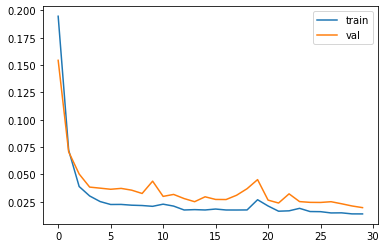

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [13]:
prediction = model.predict(np.array(X_test))
prediction = scaler.inverse_transform(prediction)
prediction=pd.DataFrame(prediction)
prediction

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,9.652025,2.390199,4.560823,5.020253,4.277972,1.285309,6.877681,5.848135,5.249225,1.906809,...,0.0,17.191833,0.000000,78.069778,76.137688,0.000000,0.0,48.198463,0.0,34.138550
1,9.362565,2.104159,4.292397,4.886446,3.812858,1.141407,6.104527,5.467911,5.014095,1.771683,...,0.0,16.677404,0.000000,74.265564,71.091835,0.000000,0.0,41.693588,0.0,33.349182
2,9.125466,1.860141,4.057205,4.771659,3.494701,1.055280,5.628488,5.124381,4.754344,1.660676,...,0.0,16.285202,0.000000,71.625916,67.756050,0.000000,0.0,37.466843,0.0,32.910023
3,8.784037,1.562435,3.726079,4.642781,3.321858,1.012399,5.298822,4.825624,4.427567,1.471476,...,0.0,15.850832,0.000000,69.874390,66.219536,0.000000,0.0,34.640762,0.0,32.749947
4,8.472211,1.279404,3.370042,4.522226,3.235330,0.995953,5.074748,4.567738,4.110741,1.255479,...,0.0,15.401160,0.000000,68.872620,65.689034,0.000000,0.0,32.571301,0.0,32.707920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,13.443984,5.881151,7.897439,6.145792,6.814648,1.856300,11.544614,8.588021,8.245832,4.516729,...,0.0,22.455269,6.949784,99.920509,100.780144,1.123580,0.0,90.825226,0.0,36.539055
283,12.919069,5.415156,7.405176,5.941404,6.428269,1.753392,10.788633,8.223869,7.871839,4.138279,...,0.0,21.728128,6.002908,96.243591,96.644135,0.832972,0.0,84.897133,0.0,35.948349
284,12.463920,4.989091,7.030994,5.800462,6.076437,1.673526,10.151159,7.949595,7.564061,3.822024,...,0.0,21.223471,5.000513,93.230072,93.315331,0.518443,0.0,79.726799,0.0,35.472469
285,11.892594,4.535513,6.576124,5.644112,5.805506,1.632148,9.716080,7.600761,7.110167,3.459538,...,0.0,20.544739,4.148600,90.995438,91.197937,0.391019,0.0,75.380600,0.0,35.346504


In [14]:
y_test=scaler.inverse_transform(y_test)
y_test=pd.DataFrame(y_test)
y_test

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,5.0,2.0,4.0,3.0,1.0,0.0,5.0,7.0,3.0,2.0,...,0.0,17.0,0.0,127.0,86.0,12.0,2.0,69.0,9.0,30.0
1,8.0,2.0,2.0,7.0,8.0,1.0,6.0,5.0,3.0,1.0,...,0.0,11.0,0.0,152.0,83.0,6.0,4.0,91.0,8.0,28.0
2,4.0,2.0,1.0,4.0,1.0,0.0,6.0,3.0,2.0,2.0,...,0.0,14.0,0.0,167.0,88.0,9.0,2.0,67.0,19.0,23.0
3,3.0,2.0,5.0,1.0,6.0,0.0,6.0,7.0,2.0,3.0,...,0.0,16.0,0.0,103.0,97.0,9.0,3.0,90.0,10.0,34.0
4,11.0,3.0,1.0,2.0,5.0,2.0,2.0,4.0,1.0,2.0,...,0.0,18.0,0.0,75.0,79.0,5.0,3.0,39.0,14.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,9.0,5.0,6.0,9.0,9.0,4.0,4.0,7.0,4.0,4.0,...,0.0,16.0,0.0,252.0,115.0,13.0,5.0,128.0,20.0,31.0
283,8.0,6.0,7.0,3.0,5.0,3.0,7.0,9.0,3.0,4.0,...,0.0,14.0,0.0,172.0,108.0,14.0,3.0,115.0,12.0,29.0
284,8.0,6.0,7.0,6.0,4.0,1.0,9.0,11.0,2.0,4.0,...,0.0,23.0,0.0,133.0,113.0,21.0,5.0,132.0,24.0,35.0
285,8.0,2.0,3.0,11.0,3.0,2.0,11.0,15.0,6.0,2.0,...,0.0,14.0,0.0,127.0,107.0,14.0,0.0,121.0,16.0,34.0


In [15]:
prediction_s = prediction.iloc[:,0]
y_test_s = y_test.iloc[:,0]
y_train_s=pd.DataFrame(y_train).iloc[:,0]
y_val_s=pd.DataFrame(y_val).iloc[:,0]

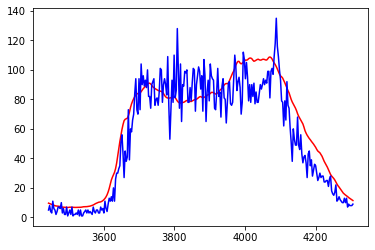

In [16]:
w=3
x1=np.linspace(0,y_train_s.shape[0]*w,y_train_s.shape[0])
x2=np.linspace(y_train_s.shape[0]*w,(y_train_s.shape[0]+y_val_s.shape[0])*w,y_val_s.shape[0])
x3=np.linspace((y_train_s.shape[0]+y_val_s.shape[0])*w,(y_train_s.shape[0]+y_val_s.shape[0]+y_test_s.shape[0])*w,y_test_s.shape[0])
# plt.plot(x1,y_train_s)
# plt.plot(x2,y_val_s)
plt.plot(x3,prediction_s,'r')
plt.plot(x3,y_test_s,'b')
